# Train model

In this model I train a model that classifies 7 guitar body types. Images are from Reverb.com and have been cleaned for duplicates as well as pictures that were zoomed in too much, or pictures of gigbacks, shop logo's, etc. FOr more details, check 'get_images.ipynb'.

First, importing the relevant packages and checking whether a GPU is available (recommended)

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
from CNN_trainer import CNN_trainer

torch.cuda.manual_seed_all(666)

## Creating datasets

First I create training, validation and testing sets. 

In [2]:
from create_datasets import create_datasets

create_datasets('data', training_prop=0.7, validation_prop=0.2, test_prop=0.1)


jazzmaster: 3431
lespaul: 21928
mustang: 1922
prs_se: 13117
sg: 5093
stratocaster: 40238
telecaster: 21616
All files combined: 107345
jazzmaster train: 2401, validation: 686, test: 344
lespaul train: 15349, validation: 4385, test: 2194
mustang train: 1345, validation: 384, test: 193
prs_se train: 9181, validation: 2623, test: 1313
sg train: 3565, validation: 1018, test: 510
stratocaster train: 28166, validation: 8047, test: 4025
telecaster train: 15131, validation: 4323, test: 2162
Totals: train: 75138, validation 21466, test: 10741


## CNN from scratch

Below I am designing a CNN from scratch. The images are converted to greyscale because I think colours are not very important for classifying guitar types. 

In [2]:
model_scratch = CNN_trainer()

# Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.Grayscale(),
                                       transforms.Resize((128,128)),                                                              
                                       transforms.ToTensor()]) 

test_transforms = transforms.Compose([transforms.Grayscale(),
                                      transforms.Resize((128,128)),
                                      transforms.ToTensor()])

model_scratch.get_loaders(10, train_transforms, test_transforms)

CUDA is available!  Training on GPU ...


Below some example images with the corresponding classes

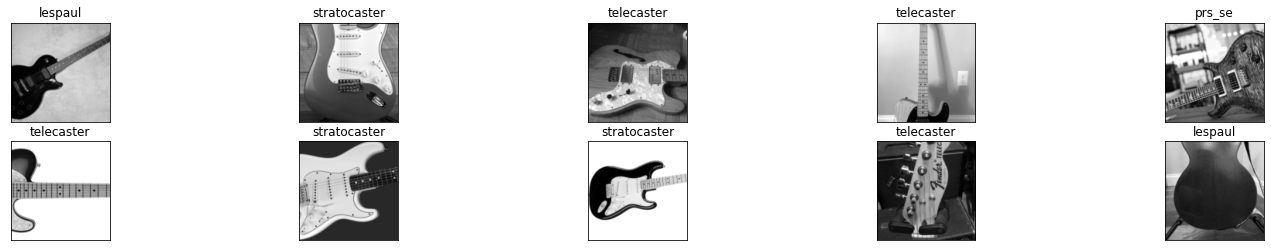

In [3]:
# obtain one batch of training images
dataiter = iter(model_scratch.train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(min(16,model_scratch.batch_size)):
    ax = fig.add_subplot(2, min(16,model_scratch.batch_size)/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(model_scratch.classes[labels[idx]])


Defining the CNN architecture

In [4]:
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 128x128x1 image tensor)
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        # convolutional layer (sees 64x64x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 32x32x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # convolutional layer (sees 16x16x64 tensor)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)

        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # linear layer (128 * 8 * 8 -> 200)
        self.fc1 = nn.Linear(128 * 8 * 8, 200)
        # linear layer (200 -> 7)
        self.fc2 = nn.Linear(200, 7)
        # dropout layer (p=0.5)
        self.dropout = nn.Dropout(.5)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        # flatten image input
        x = x.view(-1, 128 * 8 * 8)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer
        x = self.fc2(x)
        return x

# create a complete CNN
model_scratch.set_model(Net(), 'model.pt') 

# specify loss function (categorical cross-entropy)
model_scratch.criterion = nn.CrossEntropyLoss()

# specify optimizer
model_scratch.optimizer = optim.SGD(model_scratch.model.parameters(), lr=0.01)

Training the model with a max of 50 epochs. It stops after 5 epochs with less than 0.02 improvement in the loss.

In [5]:
model_scratch.train_model(max_epochs=50, stop_at=5, stopping_criterion=0.02)

 Epoch: 1 	100.00% completed
		Training Loss: 1.504 	Validation Loss: 1.355
		Validation Accuracy (Overall): 47% (10256/21466)
		Validation loss decreased (inf --> 1.355).  Saving model ...


 Epoch: 2 	100.00% completed
		Training Loss: 1.269 	Validation Loss: 1.103
		Validation Accuracy (Overall): 58% (12490/21466)
		Validation loss decreased (1.355 --> 1.103).  Saving model ...


 Epoch: 3 	18.14% completed

KeyboardInterrupt: 

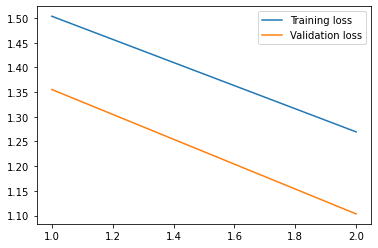

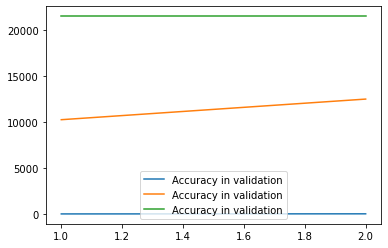

In [13]:
model_scratch.plot_scores()

In [7]:
model_scratch.test_model()

Test Loss: 1.424299

Test Accuracy of jazzmaster:  0% ( 0/344)
Test Accuracy of lespaul: 29% (651/2194)
Test Accuracy of mustang:  0% ( 0/193)
Test Accuracy of prs_se: 37% (497/1313)
Test Accuracy of    SG:  0% ( 0/510)
Test Accuracy of stratocaster: 83% (3362/4024)
Test Accuracy of telecaster: 12% (266/2162)

Test Accuracy (Overall): 44% (4776/10740)


## Transfer learning model

Below I am using the architecture and weights of the VGG16 model and adjusting the end. Also the input needs to be the same so it will be colour and sized to 224x224.

In [2]:
model_transfer = CNN_trainer()

train_transforms = transforms.Compose([transforms.Resize((224,224)),                                                              
                                       transforms.ToTensor()]) 

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor()])

model_transfer.get_loaders(40, train_transforms, test_transforms)

Getting the VGG26 model and making adjustments to it

In [3]:
vgg16 = models.vgg16(pretrained=True)

model = vgg16

# turning off weight updates in the CNN part
for param in model.features.parameters():
    param.requires_grad = False

#Shortening and changeing the fully connected part
model.classifier = nn.Sequential(*list(model.classifier.children())[:-2])
model.classifier[0] = nn.Dropout(0.6, inplace=False)
model.classifier[1] = nn.Linear(in_features=25088, out_features=4096, bias=True)
model.classifier[2] = nn.ReLU(inplace=True)
model.classifier[3] = nn.Dropout(0.6, inplace=False)
#Change the final parameter to 7 categories
model.classifier[4] = nn.Linear(in_features=4096, out_features=7, bias=True)
    
model_transfer.set_model(model, 'model_transfer.pt')

# specify loss function (categorical cross-entropy)
model_transfer.criterion = nn.CrossEntropyLoss()

# specify optimizer
model_transfer.optimizer = optim.SGD(model_scratch.model.parameters(), lr=0.01)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Training the model.

In [5]:
model_transfer.train_model(max_epochs=50, stop_at=5, stopping_criterion=0.02)

 Epoch: 1 	100.00% completed
		Training Loss: 0.747 	Validation Loss: 0.467
		Validation loss decreased (inf --> 0.467).  Saving model ...
 Epoch: 2 	100.00% completed
		Training Loss: 0.501 	Validation Loss: 0.379
		Validation loss decreased (0.467 --> 0.379).  Saving model ...
 Epoch: 3 	100.00% completed
		Training Loss: 0.422 	Validation Loss: 0.353
		Validation loss decreased (0.379 --> 0.353).  Saving model ...
 Epoch: 4 	100.00% completed
		Training Loss: 0.369 	Validation Loss: 0.325
		Validation loss decreased (0.353 --> 0.325).  Saving model ...
 Epoch: 5 	100.00% completed
		Training Loss: 0.327 	Validation Loss: 0.301
		Validation loss decreased (0.325 --> 0.301).  Saving model ...
 Epoch: 6 	100.00% completed
		Training Loss: 0.294 	Validation Loss: 0.284
		Validation loss decreased (0.301 --> 0.284).  Saving model ...
 Epoch: 7 	100.00% completed
		Training Loss: 0.264 	Validation Loss: 0.278
		Validation loss decreased (0.284 --> 0.278).  Saving model ...
 Epoch: 8 	100.

KeyboardInterrupt: 

In [6]:
model_transfer.plot_scores()

Test Loss: 0.261589

Test Accuracy of jazzmaster: 77% (268/348)
Test Accuracy of lespaul: 93% (2064/2212)
Test Accuracy of mustang: 69% (136/196)
Test Accuracy of prs_se: 90% (1199/1318)
Test Accuracy of    SG: 75% (383/510)
Test Accuracy of stratocaster: 96% (3876/4025)
Test Accuracy of telecaster: 88% (1904/2162)

Test Accuracy (Overall): 91% (9830/10771)


In [ ]:
model_transfer.test()